In [38]:
!pip install -q git+https://github.com/tensorflow/docs
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
print(tf.__version__)

2.2.0-rc2


In [0]:
class Table:
    
    def __init__(self, R, alpha):
        self.R = R
        self.alpha = alpha
        
    def check_conditions(self, x, y):
        aR = self.alpha*self.R
        
        if x > self.R or x< -self.R or (y>aR and x**2+(y-aR)**2>self.R**2) or (y<-aR and x**2+(y+aR)**2>self.R**2):
            return False
        else:
            return True
        
class Ball:
    
    def __init__(self, initial_conditions, times, R, alpha):
        
        self.x, self.y, self.vx, self.vy = np.zeros((4, len(times)))
        self.x[0], self.y[0], self.vx[0], self.vy[0] = initial_conditions
        
        self.dt = np.median(np.diff(times))
        self.times = times
        
        self.table = Table(R, alpha)
        
    def simulation_run(self):
        for i, t in enumerate(times[:-1]):
            self.update(i)
    
    def update(self, i):
        self.pos_vel_update(i)
        self.check_pos(i, self.x[i+1], self.y[i+1])
    
    def pos_vel_update(self, i):
        self.x[i+1] = self.x[i] + self.vx[i]*self.dt
        self.y[i+1] = self.y[i] + self.vy[i]*self.dt 
        self.vx[i+1] = self.vx[i]
        self.vy[i+1] = self.vy[i]
    
    
    def check_pos(self, i, x, y):
        conditions_met = self.table.check_conditions(x, y)
        
        if conditions_met:
            pass
        else:
            self.edge_adjust(i)
    
    def edge_adjust(self, i):
        
        conditions_met= True        
        while conditions_met==True:
            self.x[i+1] = self.x[i+1] + self.vx[i]*self.dt/100
            self.y[i+1] = self.y[i+1] + self.vy[i]*self.dt/100
            conditions_met = self.table.check_conditions(self.x[i+1], self.y[i+1])
        
        self.velocity_adjust(i)
    
    
    def velocity_adjust(self, i):
        vi      = np.array([self.vx[i+1], self.vy[i+1]])
        aR = self.table.R*self.table.alpha
        
        if self.y[i+1] >aR:
            n_hat   = 1/self.table.R * np.array([self.x[i+1],self.y[i+1]-aR])
            v_perp  = np.dot(vi, n_hat)*n_hat
            v_para  = vi-v_perp
            v_perp = -v_perp
            vf = v_para+v_perp
            self.vx[i+1], self.vy[i+1] = vf[0], vf[1]
        
        elif self.y[i+1]<-aR:
            n_hat   = self.table.R*np.array([self.x[i+1],self.y[i+1]+aR])   
            
            v_perp  = np.dot(vi, n_hat)*n_hat
            v_para  = vi-v_perp
            v_perp = -v_perp
            vf = v_para+v_perp
            
            self.vx[i+1], self.vy[i+1] = vf[0], vf[1]
        
        else:
            self.vx[i+1], self.vy[i+1] = -self.vx[i], self.vy[i]
    
    
    def poincare(self, phase, tol=1e-3):
        indices = []
        for i,y in enumerate(self.y[:-1]):
            if np.abs(y-phase)<tol:
                indices.append(i)
        self.p_x = self.x[indices]
        self.p_vx = self.vx[indices]
        
        indices = []
        for i,x in enumerate(self.x[:-1]):
            if np.abs(x-phase)<tol:
                indices.append(i)
        self.p_y = self.y[indices]
        self.p_vy = self.vy[indices]

In [0]:
times = np.arange(0, 100, .001)
x0, y0, vx0, vy0 = -.1,0,.4,.2
initial_cond = [x0, y0, vx0, vy0]

R = 1
alpha = [a for a in np.linspace(0, 5, 100)]


b = [Ball(initial_cond, times, R, a) for a in alpha]
sols = [bi.simulation_run() for bi in b]



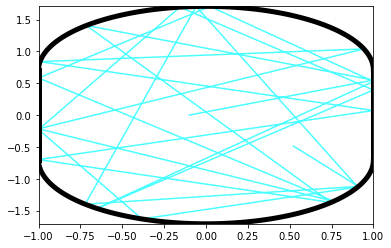

In [0]:
plot_b = b[92]

fig = plt.figure()
ax = plt.axes(xlim = (-plot_b.table.R,plot_b.table.R ),
              ylim=(-plot_b.table.R-plot_b.table.alpha*plot_b.table.R,plot_b.table.R+plot_b.table.alpha*plot_b.table.R))
line, = ax.plot([],[], c='k', zorder=2.5)
ax.plot(plot_b.x, plot_b.y, c='cyan', alpha=.7)
ax.plot([plot_b.table.R]*10,np.linspace(-plot_b.table.alpha*plot_b.table.R,plot_b.table.alpha*plot_b.table.R,10),'-k',lw=5)
ax.plot([-plot_b.table.R]*10,np.linspace(-plot_b.table.alpha*plot_b.table.R,plot_b.table.alpha*plot_b.table.R,10),'-k',lw=5)
ax.plot(plot_b.table.R*np.cos(np.linspace(0,np.pi,100)),plot_b.table.R*np.sin(np.linspace(0,np.pi,100))+plot_b.table.alpha*plot_b.table.R,'-k',lw=5)
ax.plot(plot_b.table.R*np.cos(np.linspace(np.pi,2*np.pi,100)),plot_b.table.R*np.sin(np.linspace(np.pi,2*np.pi,100))-plot_b.table.alpha*plot_b.table.R,'-k',lw=5)




In [0]:
np.random.shuffle(b)

In [0]:
train_data   = np.array([np.array([bi.x, bi.y]) for bi in b[:int(len(b)*.9)]])
train_labels = np.array([bi.table.alpha for bi in b[:int(len(b)*.9)]])
test_data   = np.array([np.array([bi.x, bi.y]) for bi in b[int(len(b)*.9):]])
test_labels = np.array([bi.table.alpha for bi in b[int(len(b)*.9):]])

In [0]:

def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation='sigmoid',input_shape=[ 2, len(times)]),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(4, activation='sigmoid'),
        layers.Flatten(),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model
model = build_model()




In [0]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

early_history = model.fit(train_data, train_labels, 
                    epochs=1000, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:6.7835,  mae:2.2008,  mse:6.8773,  val_loss:5.3609,  val_mae:1.9333,  val_mse:5.3609,  
....................................................................................................
Epoch: 100, loss:0.6864,  mae:0.6214,  mse:0.8916,  val_loss:0.7562,  val_mae:0.6614,  val_mse:0.7562,  
....................................................................................................
Epoch: 200, loss:0.0605,  mae:0.1697,  mse:0.0676,  val_loss:0.2025,  val_mae:0.3773,  val_mse:0.2025,  
..........................................................

In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Early Stopping': early_history}, metric = "loss")

NameError: ignored

In [0]:
loss, mae, mse= model.evaluate(test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))


1/1 - 0s - loss: 0.3739 - mae: 0.4334 - mse: 0.3739
Testing set Mean Abs Error:  0.43


In [0]:
model.predict(test_data).T[0],test_labels

(array([4.4488463 , 3.017729  , 4.448446  , 0.2591075 , 0.7680911 ,
        1.224157  , 3.1431105 , 0.77824366, 4.3930793 , 2.7545083 ],
       dtype=float32),
 array([4.5959596 , 2.67676768, 4.29292929, 1.06060606, 0.80808081,
        1.16161616, 1.71717172, 0.65656566, 3.53535354, 2.37373737]))

In [0]:
np.abs(model.predict(test_data).T[0] - np.array(test_labels))/np.array(test_labels)*100

array([ 3.20092579, 12.73780202,  3.62261974, 75.56986426,  4.94872853,
        5.38394835, 83.03996521, 18.53249605, 24.26138537, 16.04098614])